# Working with Chemical Data
As we discussed in our lecture, using computers to manipulate data about molecules goes [back to the infancy of modern computing.](https://pubs.acs.org/doi/abs/10.1021/cen-v030n034.p3523)
This notebook is designed to show you that tools to use computers have, indeed, evolved rapidly alongside computing.

In particular, we focus on RDKit - a library for chemoinformatics that works well with Python.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from rdkit import Chem  # Common functionality from RDKit is available in the Chem module
from rdkit.Chem import AllChem  # Most of the other functions are in AllChem and other modules
import pandas as pd
import numpy as np
import gzip
import json

## Parsing Chemical Data
The data for our lesson is stored as line-delimited JSON, where each individual record is a dictionary that contains some information about a molecule and a name that captures the molecular structure

### Part 1: Getting the Data off Disk
We first solve a problem that has nothing to do with chemistry: reading a table into Python.

In [3]:
data_path = '../datasets/qm9.json.gz'
with gzip.open(data_path, 'rt') as fp:
    record = fp.readline().strip()
print(record)

{"A":2.5832,"B":1.30797,"C":0.93888,"R2":1313.6519,"alpha":89.34,"atomic_charges":[-0.499654,0.225168,0.200368,-0.291577,-0.21091,-0.28294,-0.105237,-0.239277,-0.322535,0.124266,0.121383,0.129916,0.102653,0.100871,0.096362,0.101769,0.097331,0.102152,0.095926,0.11547,0.111787,0.226708],"bandgap":0.2487,"cv":34.347,"filename":"dsgdb9nsd_073931.xyz","g":-367.242047,"g4mp2_0k":-366.761358,"g4mp2_atom":-3.347687,"g4mp2_energy":-366.752131,"g4mp2_enthalpy":-366.751186,"g4mp2_free":-366.795572,"g4mp2_hf298":33.0693,"g4mp2_zpe":0.192623,"h":-367.197822,"homo":-0.2266,"inchi_0":"InChI=1S\/C8H13N\/c1-6-3-2-4-7(6)8-5-9-8\/h8-9H,2-5H2,1H3","inchi_1":"InChI=1S\/C8H13N\/c1-6-3-2-4-7(6)8-5-9-8\/h8-9H,2-5H2,1H3\/t8-\/m1\/s1","index":73931,"lumo":0.0221,"mu":1.8965,"n_atom":22,"n_electrons":68,"n_heavy_atoms":9,"smiles_0":"CC1=C(CCC1)C1CN1","smiles_1":"CC1=C(CCC1)[C@H]1CN1","u":-367.198766,"u0":-367.2079,"u0_atom":-3.346314,"xyz":"22\nProperties=species:S:1:pos:R:3 unique_id=ef4cdf48825f07674198527d13d

We need to do two things to make this data usable. First, take that record and parse it into a Python dictionary.

In [4]:
json.loads(record)

{'A': 2.5832,
 'B': 1.30797,
 'C': 0.93888,
 'R2': 1313.6519,
 'alpha': 89.34,
 'atomic_charges': [-0.499654,
  0.225168,
  0.200368,
  -0.291577,
  -0.21091,
  -0.28294,
  -0.105237,
  -0.239277,
  -0.322535,
  0.124266,
  0.121383,
  0.129916,
  0.102653,
  0.100871,
  0.096362,
  0.101769,
  0.097331,
  0.102152,
  0.095926,
  0.11547,
  0.111787,
  0.226708],
 'bandgap': 0.2487,
 'cv': 34.347,
 'filename': 'dsgdb9nsd_073931.xyz',
 'g': -367.242047,
 'g4mp2_0k': -366.761358,
 'g4mp2_atom': -3.347687,
 'g4mp2_energy': -366.752131,
 'g4mp2_enthalpy': -366.751186,
 'g4mp2_free': -366.795572,
 'g4mp2_hf298': 33.0693,
 'g4mp2_zpe': 0.192623,
 'h': -367.197822,
 'homo': -0.2266,
 'inchi_0': 'InChI=1S/C8H13N/c1-6-3-2-4-7(6)8-5-9-8/h8-9H,2-5H2,1H3',
 'inchi_1': 'InChI=1S/C8H13N/c1-6-3-2-4-7(6)8-5-9-8/h8-9H,2-5H2,1H3/t8-/m1/s1',
 'index': 73931,
 'lumo': 0.0221,
 'mu': 1.8965,
 'n_atom': 22,
 'n_electrons': 68,
 'n_heavy_atoms': 9,
 'smiles_0': 'CC1=C(CCC1)C1CN1',
 'smiles_1': 'CC1=C(CCC1)[C

And, second, making it easy to work with a lot of these dictionaries at once.

For this purpose, we use [Pandas](https://pandas.pydata.org/docs/user_guide/index.html).

In [5]:
data = pd.read_json(data_path, lines=True).head(1000)  # Only get the first 1000 for simplicity

In [6]:
data[['smiles_0', 'inchi_0', 'u']].head(5)

,smiles_0,inchi_0,u
0,CC1=C(CCC1)C1CN1,"InChI=1S/C8H13N/c1-6-3-2-4-7(6)8-5-9-8/h8-9H,2...",-367.198766
1,COC12CCC1C1CC21,InChI=1S/C8H12O/c1-9-8-3-2-6(8)5-4-7(5)8/h5-7H...,-387.016378
2,OC1CC2CC12,"InChI=1S/C5H8O/c6-5-2-3-1-4(3)5/h3-6H,1-2H2",-270.390923
3,CC1C2CCC1C1CC21,"InChI=1S/C9H14/c1-5-6-2-3-7(5)9-4-8(6)9/h5-9H,...",-351.155574
4,COC12CC(C1C)C2=O,"InChI=1S/C7H10O2/c1-4-5-3-7(4,9-2)6(5)8/h4-5H,...",-422.975002


The above commands read the file from disk ([`read_json`](https://pandas.pydata.org/docs/user_guide/io.html#json)) and then displays a fraction of the table. I display the table to show that this object represents, in a sense, a big table or digital spreadsheet.

We'll touch on a few concepts of Pandas throughout these notebooks but I would highly recommend [10 minutes to Pandas](https://pandas.pydata.org/docs/user_guide/10min.html) if you have not used Pandas before.

### Part 2: Parsing Chemical Structures
The molecular structure of each record are recorded as ["SMILES"](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) and ["InChI"](https://en.wikipedia.org/wiki/International_Chemical_Identifier) strings. 

*Aside*: Both of SMILES and InChI are from a long tradition of methods in chemistry for writing out molecules as a string of printable characters that can be read by computers. 
The short of it is that SMILES strings are easily human-readable and InChI guarantee a unique string. 
For example, methanol can be both `CO` or `OC` in SMILES but only `InChI=1S/CH4O/c1-2/h2H,1H3` in InChI. 

RDKit provides functionality for parsing both. Here, we are going to use the SMILES string to create a molecule object.

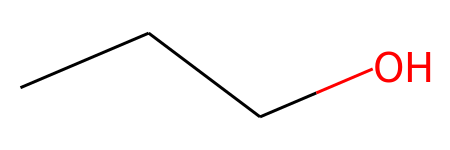

In [9]:
mol = Chem.MolFromSmiles('CCCO')
mol

If JupyterLab is a recent version, you should see a visual of [1-propanol](https://en.wikipedia.org/wiki/1-Propanol).
We will see more about what you can do with `mol` later, but the fact that your computer knew what `CCCO` means is because RDKit can read SMILES.

Now, let's parse all of the molecules using Panda's map function. 

In [10]:
data['mol'] = data['smiles_0'].map(Chem.MolFromSmiles)

## Manipulating Molecules
Once molecules are parsed, you can make many kinds of queries about them. 

For now, we use the 1-Propanol molecule from earlier as an example

### Basic Functionality
RDKit treats the molecule as a Python object and, accordingly, you can interact with it using some functions

In [11]:
for i, a in enumerate(mol.GetAtoms()):
    print(f'Atom {i} is an {a.GetSymbol()}')

Atom 0 is an C
Atom 1 is an C
Atom 2 is an C
Atom 3 is an O


Note that it initially treats the molecule with _implicit_ hydrogrens, which you can add by calling a method from the `Chem` module

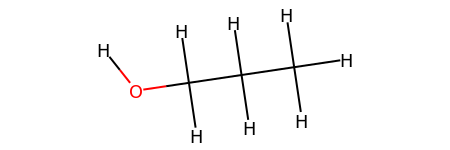

In [12]:
mol = Chem.AddHs(mol)
mol

In [13]:
for i, a in enumerate(mol.GetAtoms()):
    print(f'Atom {i} is an {a.GetSymbol()}')

Atom 0 is an C
Atom 1 is an C
Atom 2 is an C
Atom 3 is an O
Atom 4 is an H
Atom 5 is an H
Atom 6 is an H
Atom 7 is an H
Atom 8 is an H
Atom 9 is an H
Atom 10 is an H
Atom 11 is an H


You can also do more sophisticated things like, find all rings

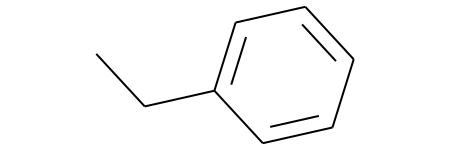

In [17]:
toluene = Chem.MolFromSmiles('CCc1ccccc1')
toluene

In [18]:
r = toluene.GetRingInfo()
print(f'Toluene has {r.NumRings()} ring')

Toluene has 1 ring


You can imagine that RDKit has many capabilities for describing molecules

### Descriptors
Hence, RDKit is a source of [many different "descriptors" for molecules](https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors). We'll demonstrate a few for concepts.

Some generate `float` or `int` values, which can be directly used by Python

In [19]:
print(f'Toluene has {AllChem.CalcNumRotatableBonds(toluene)} rotatable bonds')

Toluene has 1 rotatable bonds


Others are in C++ objects which, while similar to Python objects, should be converted to a Python standard type.

*Aside*: This has to do with parts of RDKit being written in C++. 

In [20]:
r = AllChem.BCUT2D(mol)
r

### Fingerprints
Another class of descriptor are "fingerprints," which seek to encode the entire molecule as a fixed length vector of bits. RDKit [implements a few of these](https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-fingerprints)

In [21]:
bv = AllChem.GetMorganFingerprintAsBitVect(mol, 4, 16)
bv

In [22]:
np.asarray(bv)

array([0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1])

As we will see later, both fingerprints and descriptors provide complementary routes for training machine learning models.